In [ ]:
pip install windrose

In [ ]:
pip install python-ternary

In [ ]:
!pip install tensorflow keras scikeras

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from matplotlib.dates import DateFormatter
from windrose import WindroseAxes
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import ternary
from scipy.stats import gaussian_kde
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/Colab Notebooks/London2_21_23.csv'

df_raw = pd.read_csv(file_path)

df_raw = df_raw.drop(columns=['v10', 'v2.5', 'nv10', 'nv2.5'])
df_raw.head()

,source,site,code,date,co,nox,no2,no,o3,so2,pm10,pm2.5,ws,wd,air_temp
0,aurn,London N. Kensington,KC1,2021-01-01T00:00:00Z,0.140844,23.95954,21.65101,1.50558,28.53851,3.62866,35.150,30.448,1.5,314.9,-2.1
1,aurn,London N. Kensington,KC1,2021-01-01T01:00:00Z,0.129106,37.21805,30.42826,4.42819,14.90123,3.43251,65.475,55.802,2.1,318.7,-2.9
2,aurn,London N. Kensington,KC1,2021-01-01T02:00:00Z,0.114435,21.95730,19.81852,1.39488,31.63185,3.53058,32.675,28.278,1.9,310.8,-3.6
3,aurn,London N. Kensington,KC1,2021-01-01T03:00:00Z,0.082159,20.84682,19.37004,0.96313,28.98754,2.94215,17.600,15.613,2.0,309.3,-4.0
4,aurn,London N. Kensington,KC1,2021-01-01T04:00:00Z,0.105633,22.71445,20.72844,1.29525,21.80302,1.17686,21.650,19.764,2.0,300.4,-4.5


In [ ]:
file_path = '/content/drive/My Drive/Colab Notebooks/GL_metadata.csv'

df_sites = pd.read_csv(file_path)
df_sites.head()

,source,code,site,site_type,latitude,longitude,variable,Parameter_name,start_date,end_date,ratified_to,zone,agglomeration,local_authority
0,aurn,ABD,Aberdeen,Urban Background,57.15736,-2.094278,O3,Ozone,2003-08-01T00:00:00Z,2021-09-20,2021-09-20T00:00:00Z,North East Scotland,NaN,Aberdeen City
1,aurn,ABD,Aberdeen,Urban Background,57.15736,-2.094278,NO,Nitric oxide,1999-09-18T00:00:00Z,2021-09-20,2021-09-20T00:00:00Z,North East Scotland,NaN,Aberdeen City
2,aurn,ABD,Aberdeen,Urban Background,57.15736,-2.094278,NO2,Nitrogen dioxide,1999-09-18T00:00:00Z,2021-09-20,2021-09-20T00:00:00Z,North East Scotland,NaN,Aberdeen City
3,aurn,ABD,Aberdeen,Urban Background,57.15736,-2.094278,NOx,Nitrogen oxides as nitrogen dioxide,1999-09-18T00:00:00Z,2021-09-20,2021-09-20T00:00:00Z,North East Scotland,NaN,Aberdeen City
4,aurn,ABD,Aberdeen,Urban Background,57.15736,-2.094278,SO2,Sulphur dioxide,2001-01-01T00:00:00Z,2007-09-30,2007-09-30T00:00:00Z,North East Scotland,NaN,Aberdeen City


# Merge two datesets

In [ ]:
# Select features to merge
df_sites_selected = df_sites[["code", "latitude", "longitude"]]

# Merge two datesets
df_merge = pd.merge(df_raw, df_sites_selected, on="code", how="left")

In [ ]:
# Change the date type
df_merge['date'] = pd.to_datetime(df_merge['date'], format='%Y-%m-%dT%H:%M:%SZ', utc=True)

In [ ]:
rows_raw = df_raw.shape[0]
print(f'df_raw has {rows_raw} rows')

df_London = df_merge.drop_duplicates()
rows_count = df_London.shape[0]
print(f'df_London has {rows_count} rows')

df_raw has 52560 rows
df_London has 52560 rows


In [ ]:
df_London.reset_index(drop=True, inplace=True)
df_London.head(-10)

,source,site,code,date,co,nox,no2,no,o3,so2,pm10,pm2.5,ws,wd,air_temp,latitude,longitude
0,aurn,London N. Kensington,KC1,2021-01-01 00:00:00+00:00,0.140844,23.95954,21.65101,1.50558,28.53851,3.62866,35.150,30.448,1.5,314.9,-2.1,51.52105,-0.213492
1,aurn,London N. Kensington,KC1,2021-01-01 01:00:00+00:00,0.129106,37.21805,30.42826,4.42819,14.90123,3.43251,65.475,55.802,2.1,318.7,-2.9,51.52105,-0.213492
2,aurn,London N. Kensington,KC1,2021-01-01 02:00:00+00:00,0.114435,21.95730,19.81852,1.39488,31.63185,3.53058,32.675,28.278,1.9,310.8,-3.6,51.52105,-0.213492
3,aurn,London N. Kensington,KC1,2021-01-01 03:00:00+00:00,0.082159,20.84682,19.37004,0.96313,28.98754,2.94215,17.600,15.613,2.0,309.3,-4.0,51.52105,-0.213492
4,aurn,London N. Kensington,KC1,2021-01-01 04:00:00+00:00,0.105633,22.71445,20.72844,1.29525,21.80302,1.17686,21.650,19.764,2.0,300.4,-4.5,51.52105,-0.213492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52545,aurn,London Marylebone Road,MY1,2023-12-31 09:00:00+00:00,0.197914,48.76875,29.64375,12.47300,44.10497,0.79827,11.594,4.000,6.0,218.1,8.2,51.52253,-0.154611
52546,aurn,London Marylebone Road,MY1,2023-12-31 10:00:00+00:00,0.186272,47.43000,25.43625,14.34395,48.09637,0.79827,7.730,6.000,6.4,223.6,8.4,51.52253,-0.154611
52547,aurn,London Marylebone Road,MY1,2023-12-31 11:00:00+00:00,0.221198,57.56625,32.51250,16.33963,41.71013,1.06436,7.730,6.000,6.2,232.5,9.1,51.52253,-0.154611
52548,aurn,London Marylebone Road,MY1,2023-12-31 12:00:00+00:00,0.256124,73.44000,37.86750,23.19978,37.12002,1.06436,10.628,4.000,6.1,235.9,9.3,51.52253,-0.154611


In [ ]:
# Convert specific columns to numeric type
cols_to_convert = ['co', 'nox', 'no2', 'no', 'o3', 'so2', 'pm10', 'pm2.5', 'ws', 'wd', 'air_temp']

for col in cols_to_convert:
    df_London[col] = pd.to_numeric(df_London[col], errors='coerce')

<ipython-input-12-f8ed31173e32>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_London[col] = pd.to_numeric(df_London[col], errors='coerce')


In [ ]:
df_London = df_London.drop(columns=['source', 'latitude', 'longitude'])

# 1. Missing values

## 1.1 Check missing values

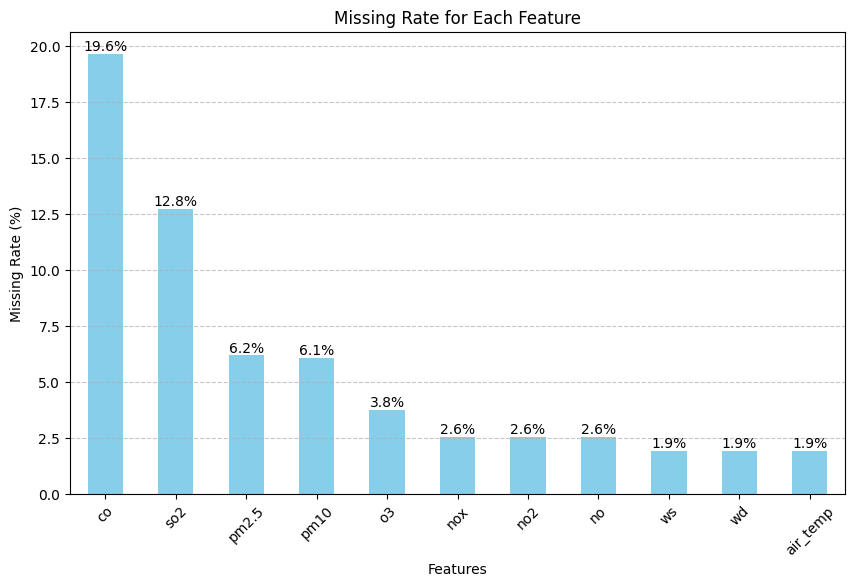

In [ ]:
# Calculate the number of missing values for each feature
missing_values = df_London.isnull().sum()

# Total number of rows
total_rows = df_London.shape[0]

# Calculate the missing rate
missing_rate = (missing_values / total_rows) * 100

# Drop 'site', 'code', 'date' columns
missing_rate = missing_rate.drop(['site', 'code', 'date'])

# Sort by missing rate in descending order
missing_rate = missing_rate.sort_values(ascending=False)

# Plot the chart
plt.figure(figsize=(10, 6))
bars = missing_rate.plot(kind='bar', color='skyblue')
plt.title('Missing Rate for Each Feature')
plt.xlabel('Features')
plt.ylabel('Missing Rate (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with the missing rate percentage
for bar in bars.patches:
    height = bar.get_height()
    if height > 0:
        plt.annotate(f'{height:.1f}%',
                     (bar.get_x() + bar.get_width() / 2, height),
                     ha='center', va='bottom')

plt.show()

### Data less than and equal to 0 in the pollutant concentration features are replaced with the smallest positive value.

In [ ]:
columns = ['co', 'nox', 'no2', 'no', 'o3', 'so2', 'pm10', 'pm2.5']

# Function to replace values
def replace_non_positive(df, column):
    # Get the minimum positive value in the column
    min_positive = df[df[column] > 0][column].min()
    # Replace values less than or equal to 0 with the minimum positive value
    df[column] = df[column].apply(lambda x: min_positive if x <= 0 else x)

# Apply the function to each column
for col in columns:
    replace_non_positive(df_London, col)

## 1.2 Imputation

Calculate the largest length of gap (n=8):

If missing gap <= n: linear imputation

If missing gap > n: Iterative Imputation

### During imputation, ensure that the imputation value of pollutant concentration is greater than or equal to the minimum positive value of the current value that is not missing. (Pollutant concentrations cannot be non-positive.)

## Linear Imputation

In [ ]:
df_London_gap = df_London.copy()

variables = ['co', 'nox', 'no2', 'no', 'o3', 'so2', 'pm10', 'pm2.5', 'ws', 'wd', 'air_temp']
pollutant_columns = ['co', 'nox', 'no2', 'no', 'o3', 'so2', 'pm10', 'pm2.5']  # Only these columns need to be > 0

# Function to perform linear interpolation for gaps <= 8 and ensure values > min positive value for pollutant columns
def linear_interpolation(df, variable, max_gap):
    df[variable] = df[variable].interpolate(method='linear', limit=max_gap)
    if variable in pollutant_columns:
        min_positive = df[df[variable] > 0][variable].min()  # Get the minimum positive value in the column
        df[variable] = df[variable].apply(lambda x: min_positive if x <= 0 else x)
    return df

# Perform linear interpolation for gaps <= 8 for each variable
for variable in variables:
    df_London_gap = linear_interpolation(df_London_gap, variable, 8)

## Iterative Imputation

In [ ]:
# Function to perform iterative imputation for large gaps
def iterative_imputation(df, variables):
    imputer = IterativeImputer(random_state=42)
    df_imputed = df.copy()
    df_imputed[variables] = imputer.fit_transform(df_imputed[variables])

    # Ensure that the imputed values for pollutant columns are greater than the minimum positive value
    for variable in pollutant_columns:
        min_positive = df[df[variable] > 0][variable].min()  # Get the minimum positive value in the column
        df[variable] = df[variable].apply(lambda x: min_positive if x <= 0 else x)
        return df_imputed

# Perform iterative imputation for large gaps
df_London_nomissing = iterative_imputation(df_London_gap, variables)

df_London_nomissing.head()

,site,code,date,co,nox,no2,no,o3,so2,pm10,pm2.5,ws,wd,air_temp
0,London N. Kensington,KC1,2021-01-01 00:00:00+00:00,0.140844,23.95954,21.65101,1.50558,28.53851,3.62866,35.150,30.448,1.5,314.9,-2.1
1,London N. Kensington,KC1,2021-01-01 01:00:00+00:00,0.129106,37.21805,30.42826,4.42819,14.90123,3.43251,65.475,55.802,2.1,318.7,-2.9
2,London N. Kensington,KC1,2021-01-01 02:00:00+00:00,0.114435,21.95730,19.81852,1.39488,31.63185,3.53058,32.675,28.278,1.9,310.8,-3.6
3,London N. Kensington,KC1,2021-01-01 03:00:00+00:00,0.082159,20.84682,19.37004,0.96313,28.98754,2.94215,17.600,15.613,2.0,309.3,-4.0
4,London N. Kensington,KC1,2021-01-01 04:00:00+00:00,0.105633,22.71445,20.72844,1.29525,21.80302,1.17686,21.650,19.764,2.0,300.4,-4.5


In [ ]:
columns = ['co', 'nox', 'no2', 'no', 'o3', 'so2', 'pm10', 'pm2.5']

# Function to replace values
def replace_non_positive(df, column):
    # Get the minimum positive value in the column
    min_positive = df[df[column] > 0][column].min()
    # Replace values less than or equal to 0 with the minimum positive value
    df[column] = df[column].apply(lambda x: min_positive if x <= 0 else x)

# Apply the function to each column
for col in columns:
    replace_non_positive(df_London_nomissing, col)

In [ ]:
missing_values = df_London_nomissing.isnull().sum()
missing_values

site        0
code        0
date        0
co          0
nox         0
no2         0
no          0
o3          0
so2         0
pm10        0
pm2.5       0
ws          0
wd          0
air_temp    0
dtype: int64

# 2.EDA

# Check the descriptive statistics

In [ ]:
# View the descriptive statistics of df_London_nomissing
description = df_London_nomissing.describe()

print(description)

                 co           nox           no2            no            o3  \
count  52560.000000  52560.000000  52560.000000  52560.000000  52560.000000   
mean       0.277512     59.286127     30.848312     18.549076     40.148256   
std        0.192355     65.424440     22.198401     30.494780     25.150740   
min        0.011642      0.382500      0.382500      0.059190      0.199570   
25%        0.150472     14.636050     12.622500      0.873110     20.156570   
50%        0.221198     34.425000     25.513910      4.864470     38.716580   
75%        0.349260     79.625155     44.752500     22.700860     57.675730   
max        2.491388    842.265000    241.357500    471.728860    187.595800   

                so2          pm10         pm2.5            ws            wd  \
count  52560.000000  52560.000000  52560.000000  52560.000000  52560.000000   
mean       1.321607     16.119842      9.892371      3.392205    193.274341   
std        1.495047     10.359003      7.638073    

NOx, O3, PM10 have a large fluctuation range and may be affected by factors such as season and weather.

# Check the correlation of features

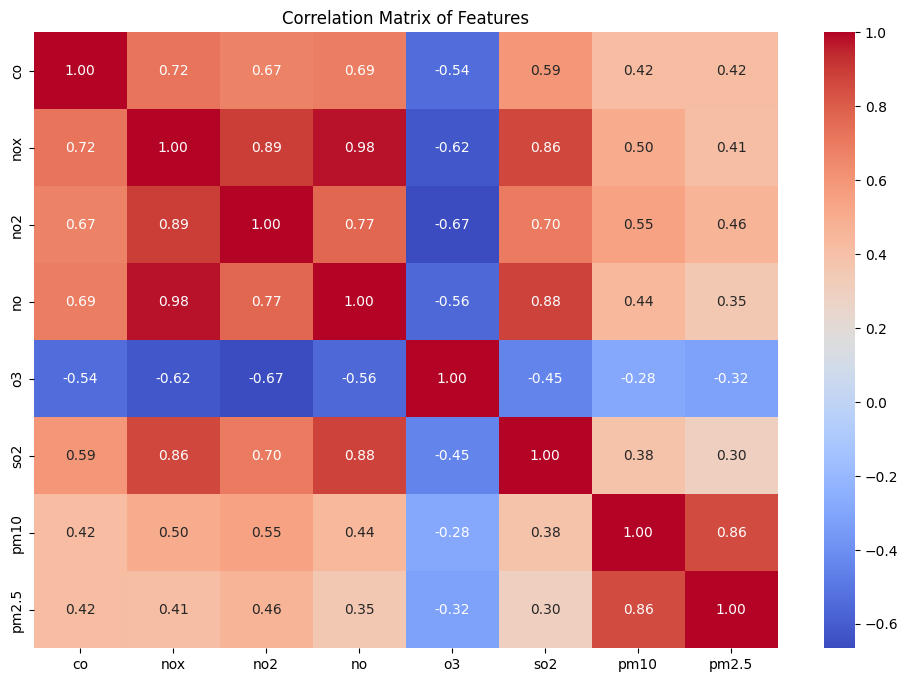

In [ ]:
variables = ['co', 'nox', 'no2', 'no', 'o3', 'so2', 'pm10', 'pm2.5']

# Ensure all relevant columns are numeric
df_London_nomissing[variables] = df_London_nomissing[variables].apply(pd.to_numeric, errors='coerce')

correlation_matrix = df_London[variables].corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

*   PM2.5 has a high correlation with PM10 and has a moderate correlation with other pollutant concentrations.
*   Because O3 acts as a reactant of chemical reactions in the atmosphere, it is negatively correlated with the concentration of other pollutants.
*   There is a strong correlation between nitrogen oxides and subsequent dimensionality reduction is required.
*   There is also a strong correlation between SO2 and nitrogen oxides.






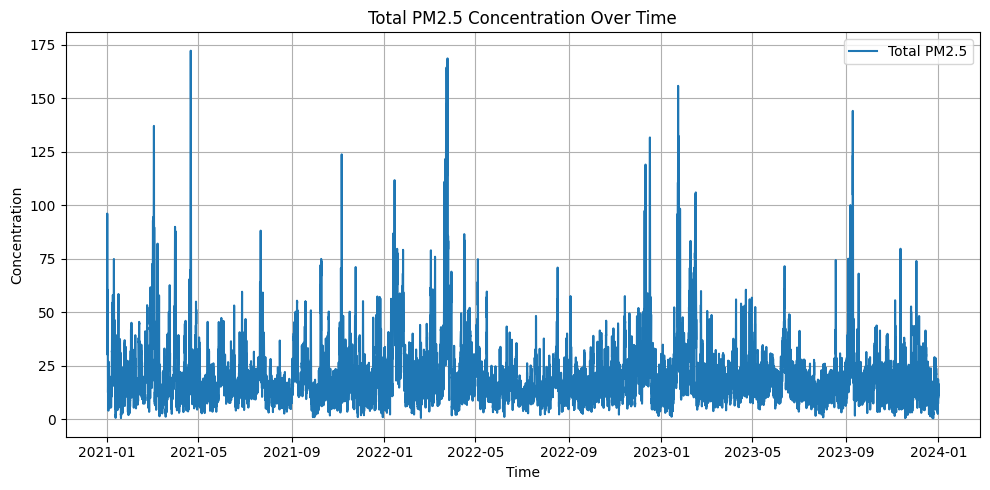

In [ ]:
# Pivot the data to have separate columns for each station
df_pivot = df_London_nomissing.pivot(index='date', columns='code', values='pm2.5')

# Calculate the total PM2.5 by summing the values from both stations
df_pivot['pm2.5_total'] = df_pivot.sum(axis=1)

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(df_pivot.index, df_pivot['pm2.5_total'], label='Total PM2.5')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Total PM2.5 Concentration Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

From the time series chart for three consecutive years from 2021 to 2023, it can be seen that PM2.5 shows obvious seasonal fluctuations.

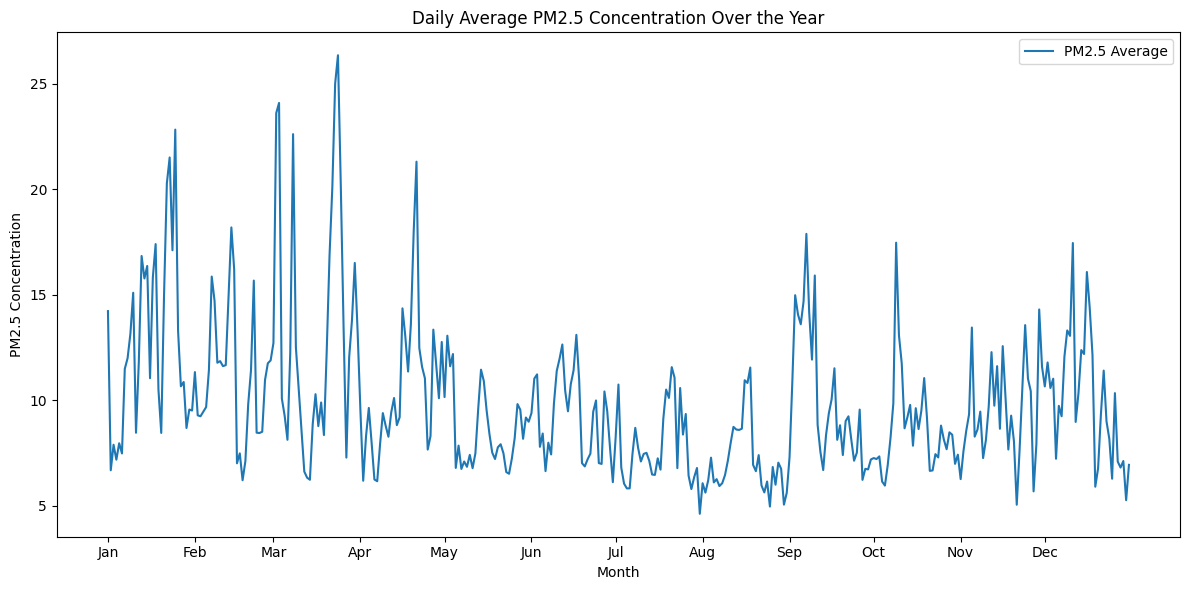

In [ ]:
df_London_nomissing['day_of_year'] = df_London_nomissing['date'].dt.strftime('%m-%d')

daily_mean_pm25 = df_London_nomissing.groupby('day_of_year')['pm2.5'].mean().reset_index()

daily_mean_pm25['day_of_year'] = pd.to_datetime(daily_mean_pm25['day_of_year'], format='%m-%d')

# Sort by day_of_year to ensure proper order
daily_mean_pm25 = daily_mean_pm25.sort_values(by='day_of_year')

plt.figure(figsize=(12, 6))
plt.plot(daily_mean_pm25['day_of_year'], daily_mean_pm25['pm2.5'], label='PM2.5 Average')

plt.xlabel('Month')
plt.ylabel('PM2.5 Concentration')
plt.title('Daily Average PM2.5 Concentration Over the Year')

month_starts = pd.date_range(start='2021-01-01', end='2021-12-31', freq='MS').strftime("%m-%d")
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(daily_mean_pm25[daily_mean_pm25['day_of_year'].dt.strftime("%m-%d").isin(month_starts)]['day_of_year'], month_labels)

plt.legend()
plt.tight_layout()
plt.show()

df_London_nomissing.drop(columns=['day_of_year'], inplace=True)

The low PM2.5 concentration in May-August compared to other months suggests that PM2.5 may be related to temperature.

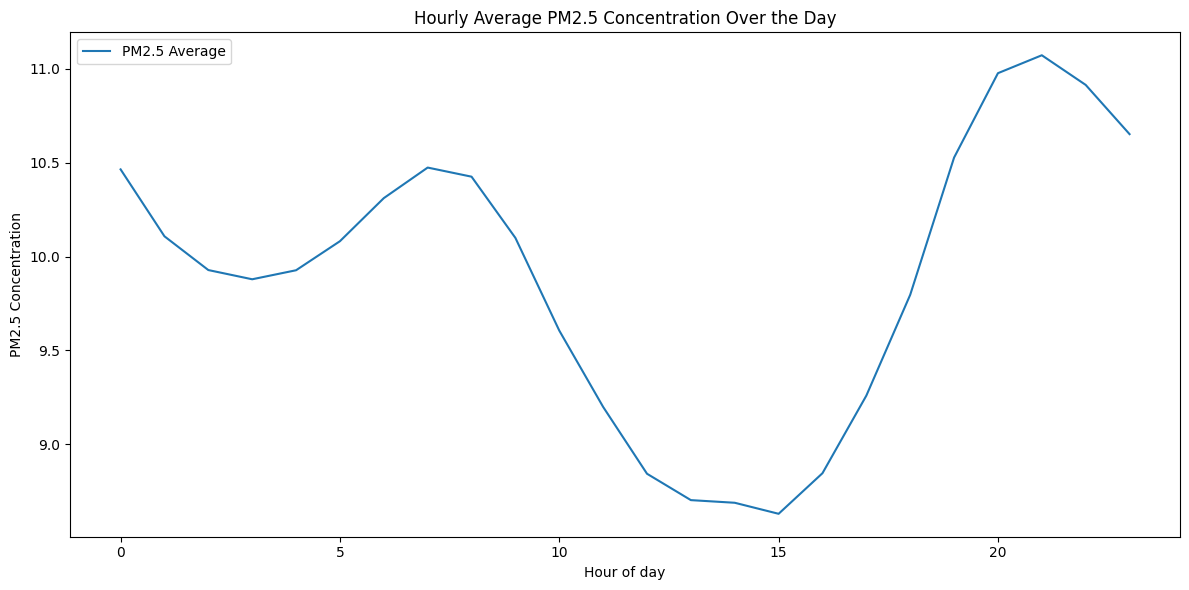

In [ ]:
# Create a new column for the hour of the day
df_London_nomissing['hour'] = df_London_nomissing['date'].dt.hour

# Group by 'hour' and calculate the mean for each hour
hourly_mean_pm25 = df_London_nomissing.groupby('hour')['pm2.5'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))

# Plot pm2.5 average over hours of the day
plt.plot(hourly_mean_pm25['hour'], hourly_mean_pm25['pm2.5'], label='PM2.5 Average')

# Set the labels and title
plt.xlabel('Hour of day')
plt.ylabel('PM2.5 Concentration')
plt.title('Hourly Average PM2.5 Concentration Over the Day')

# Show the plot
plt.legend()
plt.tight_layout()
plt.show()

# Drop the newly added 'hour' column to restore the original dataframe
df_London_nomissing.drop(columns=['hour'], inplace=True)

*   The concentration of PM2.5 may be affected by traffic emissions, and the concentration of PM2.5 will increase significantly during the morning and evening peak hours.
*   We need our model to be able to make accurate predictions over different time periods.



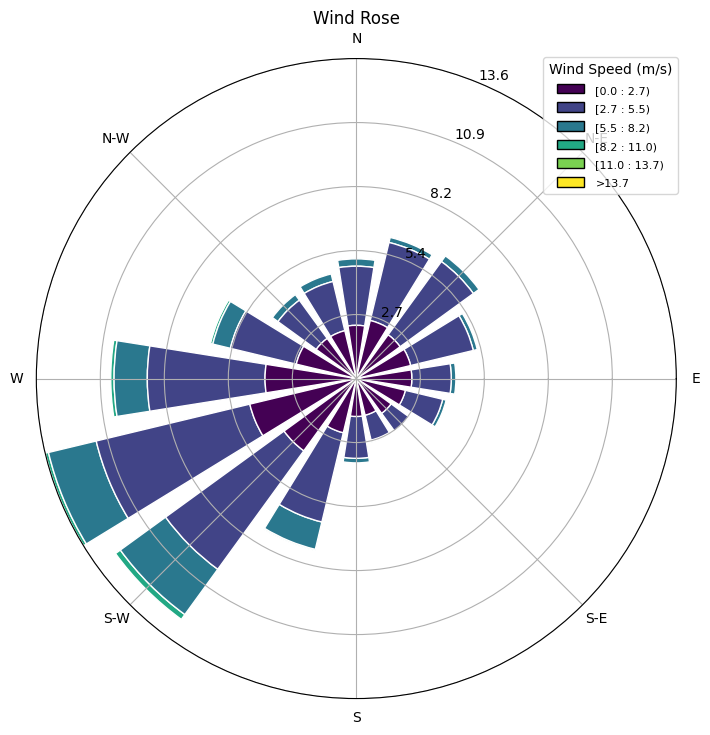

In [ ]:
# Create wind rose plot
fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax(fig=fig)

# Plot wind speed (ws) against wind direction (wd)
ax.bar(df_London_nomissing['wd'], df_London_nomissing['ws'], normed=True, opening=0.8, edgecolor='white')

ax.set_legend(title="Wind Speed (m/s)", loc='best')

plt.title('Wind Rose')
plt.show()

The two sites are about 4km apart and the prevailing winds are from the west (W) to the southwest (SW), with most winds concentrated between 2.7 and 5.5 m/s.


*   Wind direction can help identify the direction of pollution sources.
*   Wind speed can affect the diffusion of pollutants.

Adding wind direction and wind speed can improve the accuracy of prediction.



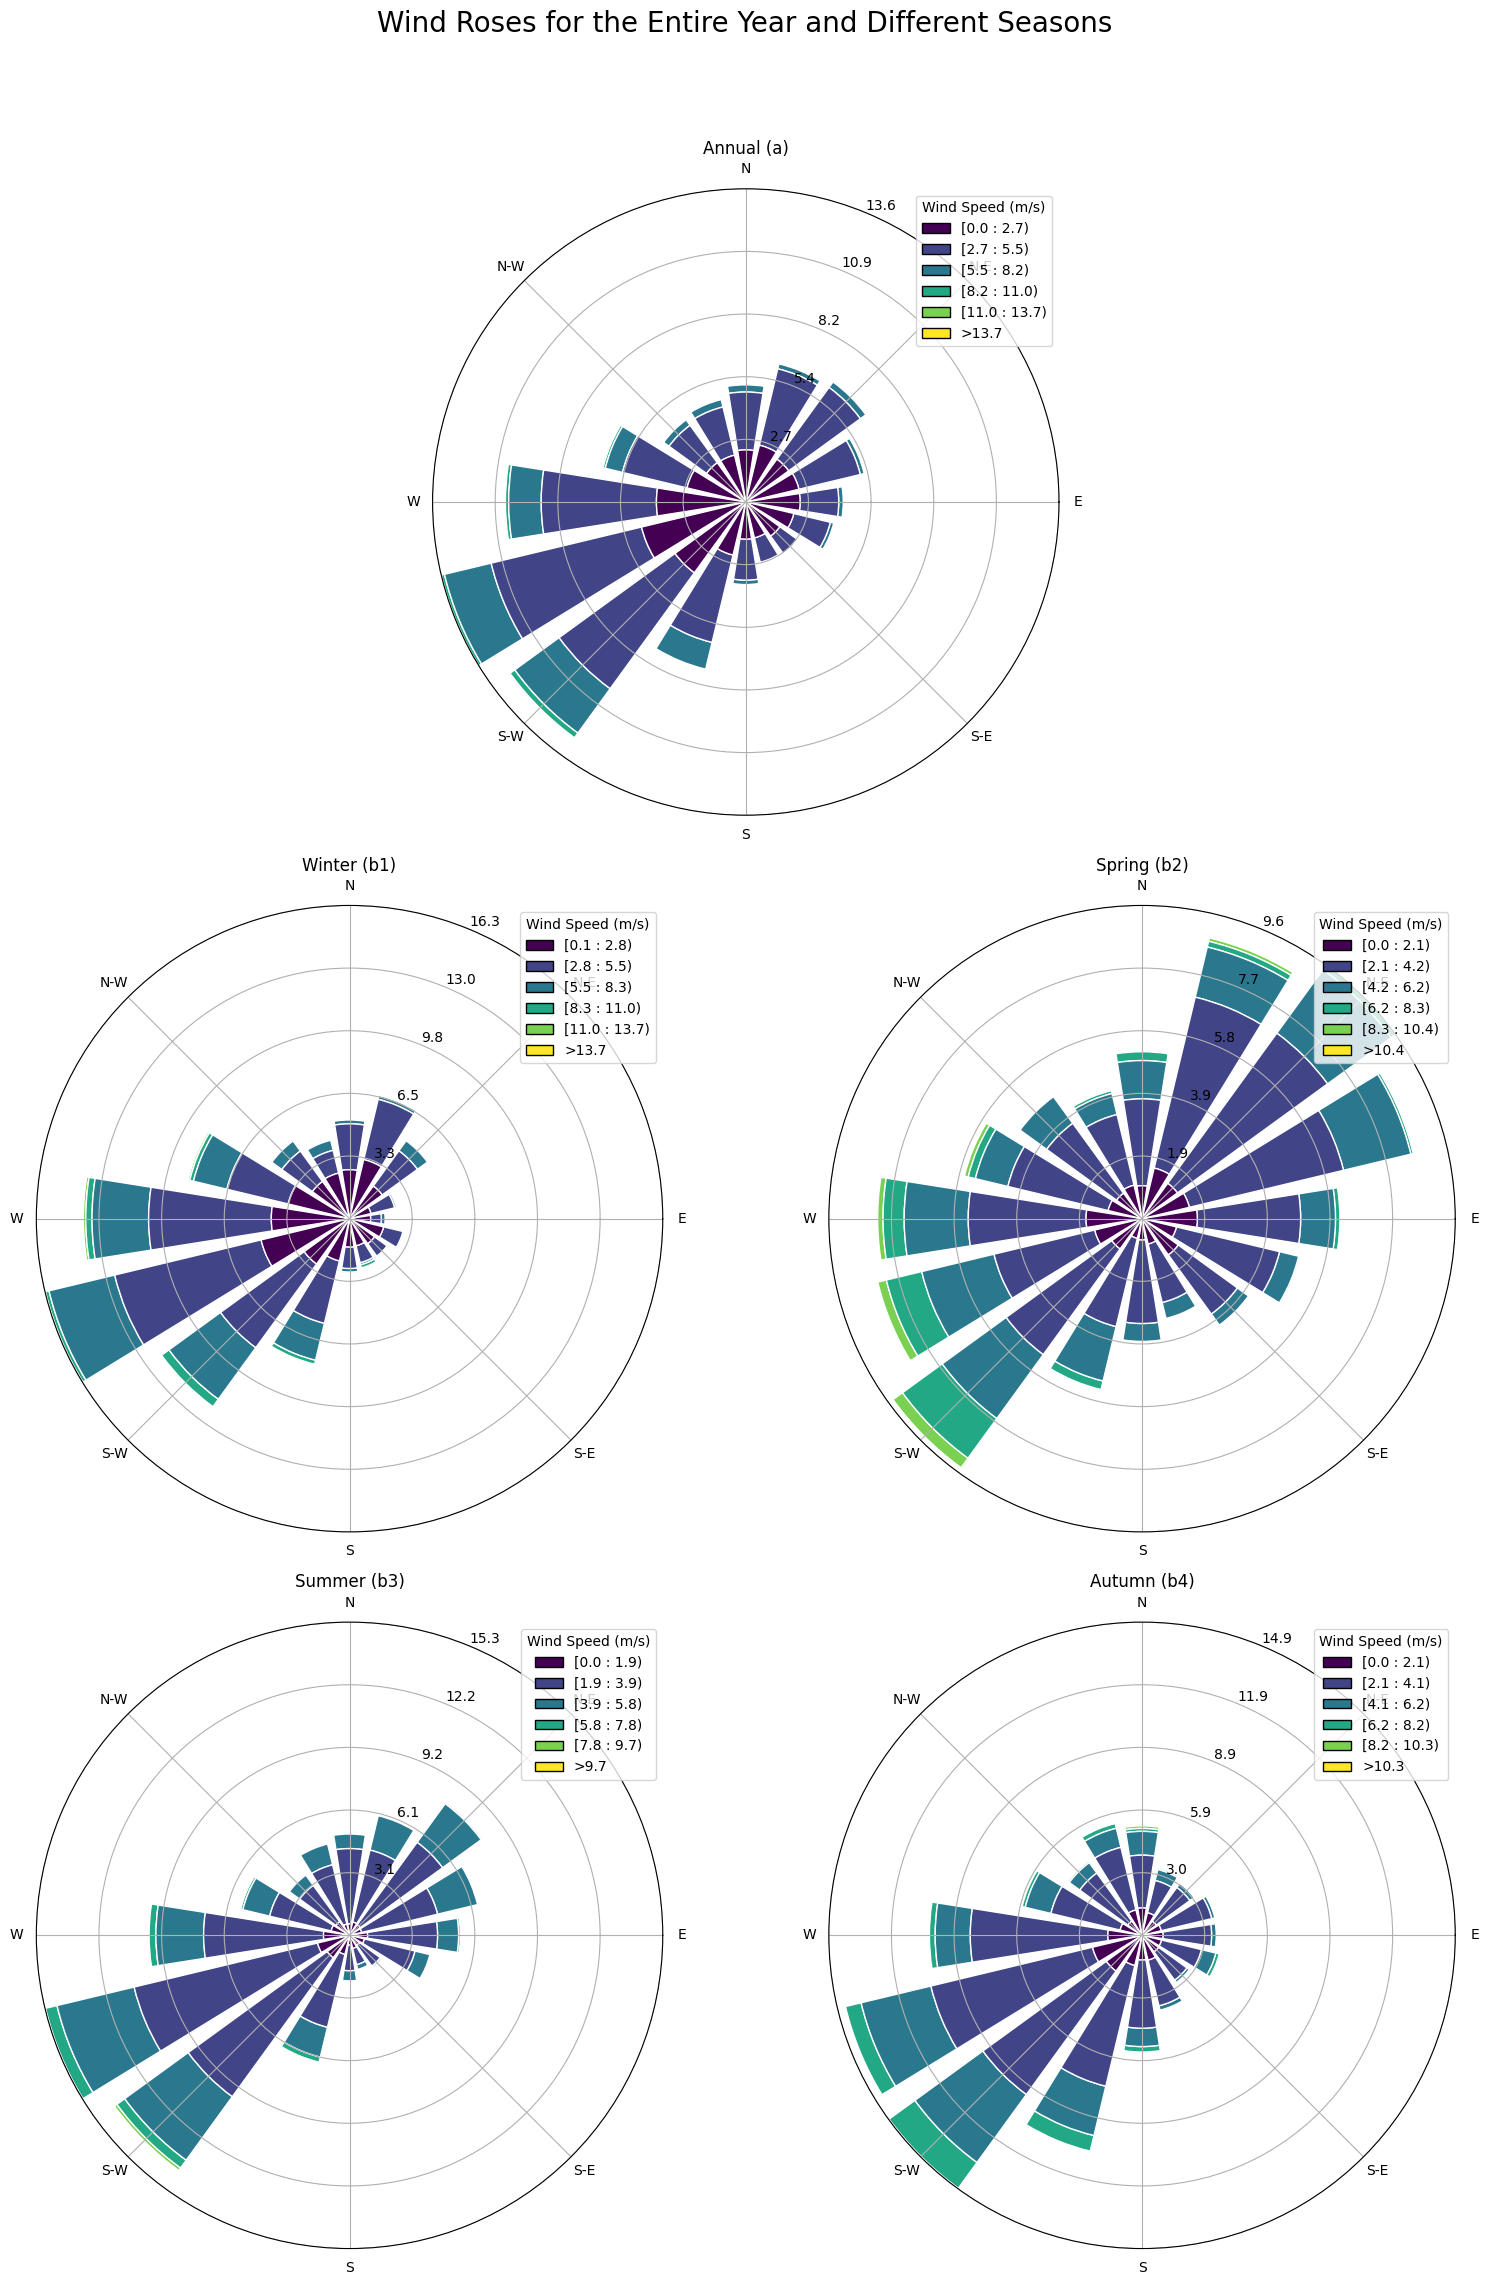

In [ ]:
# Add a column indicating the season
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_London_nomissing['season'] = df_London_nomissing['date'].apply(get_season)

# Plot wind roses for each season
seasons = ['Annual', 'Winter', 'Spring', 'Summer', 'Autumn']
fig = plt.figure(figsize=(16, 24))

# Annual wind rose plot
ax_annual = fig.add_subplot(3, 1, 1, projection='windrose')
ax_annual.bar(df_London_nomissing['wd'], df_London_nomissing['ws'], normed=True, opening=0.8, edgecolor='white')
ax_annual.set_title('Annual (a)')
ax_annual.legend(title="Wind Speed (m/s)", loc='upper right')

# Seasonal wind rose plots
for i, season in enumerate(seasons[1:]):
    ax = fig.add_subplot(3, 2, i + 3, projection='windrose')
    season_data = df_London_nomissing[df_London_nomissing['season'] == season]
    ax.bar(season_data['wd'], season_data['ws'], normed=True, opening=0.8, edgecolor='white')
    ax.set_title(f'{season} (b{i+1})')
    ax.legend(title="Wind Speed (m/s)", loc='upper right')

plt.suptitle('Wind Roses for the Entire Year and Different Seasons', size=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

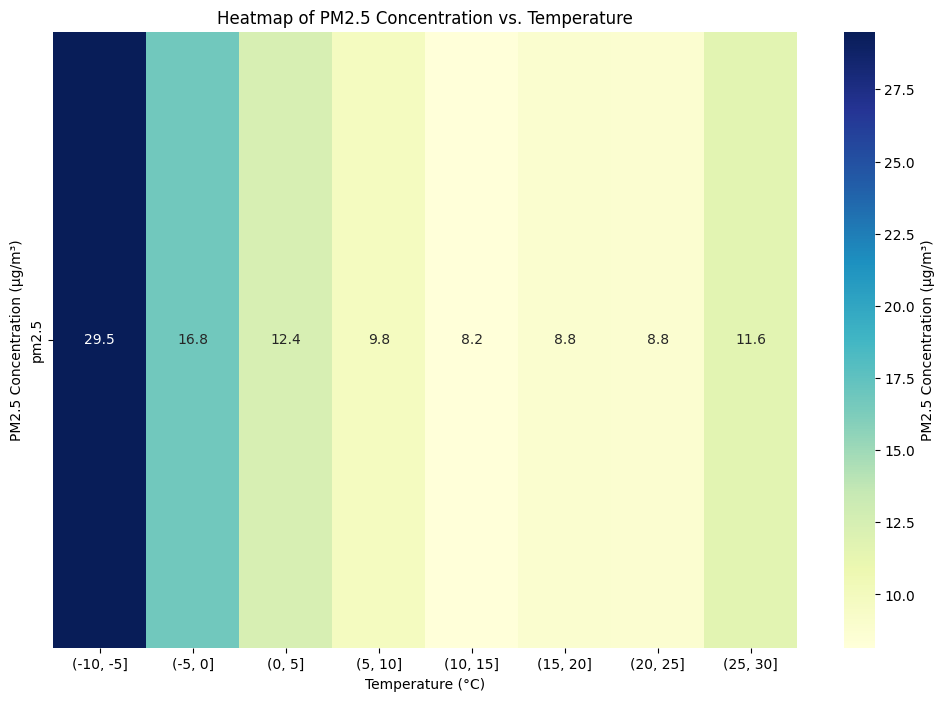

In [ ]:
# Create temperature bins
df_London_nomissing['temp_bin'] = pd.cut(df_London_nomissing['air_temp'], bins=np.arange(-10, 35, 5))

# Calculate mean PM2.5 for each temperature bin
heatmap_data = df_London_nomissing.groupby('temp_bin')['pm2.5'].mean().reset_index()

# Prepare data for heatmap
heatmap_data_pivot = heatmap_data.set_index('temp_bin').T

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_pivot, cmap='YlGnBu', annot=True, fmt=".1f", cbar_kws={'label': 'PM2.5 Concentration (µg/m³)'})
plt.title('Heatmap of PM2.5 Concentration vs. Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.show()



*   When the temperature is low, pollutants are not easy to spread, and will increase heating requirements, so the concentration of PM2.5 is high at low temperatures.
*   When the temperature is above 25°, the use of air conditioning leads to a small increase in pm2.5 again



It can be seen that temperature has a great impact on PM2.5, so the temperature factor should be considered in the prediction.

# Make a comparison between ACF and PACF

## ACF

<Figure size 1200x600 with 0 Axes>

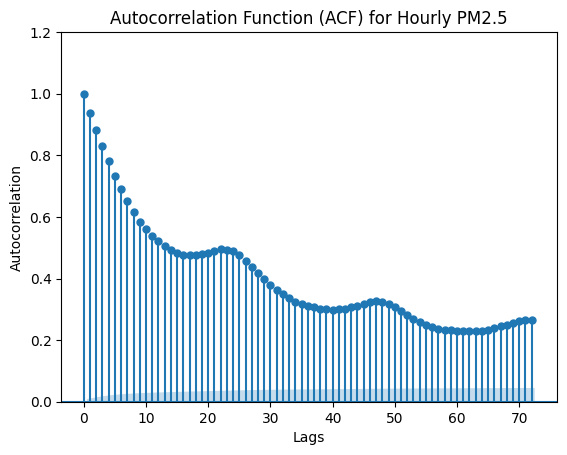

In [ ]:
# Plot Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(df_London_nomissing['pm2.5'], lags=72)
plt.title('Autocorrelation Function (ACF) for Hourly PM2.5')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.ylim(0, 1.2)
plt.show()

In [ ]:
acf_values = acf(df_London_nomissing['pm2.5'], nlags=50)

value = []
for i in range(25):
    value.append(acf_values[i])
    print(i, value[i])

0 1.0
1 0.9366547897913641
2 0.8837358118852133
3 0.8314481687408964
4 0.7802785264211995
5 0.7326600674053849
6 0.6894205478506311
7 0.6502257910527259
8 0.615399576182169
9 0.5847794761125121
10 0.559306894907299
11 0.5388551414404478
12 0.5210383313004471
13 0.5064324020802734
14 0.49374410664931273
15 0.4841871901537225
16 0.4779468965558839
17 0.4748798191603944
18 0.4751748208083862
19 0.4783726472334211
20 0.48444442741490046
21 0.4899014627139197
22 0.4947123307655939
23 0.4936563581216297
24 0.4884516845273585


In [ ]:
acf_values[47]

0.3254438359990098

In [ ]:
# Calculate ACF values
acf_values = acf(df_London_nomissing['pm2.5'], nlags=48)

# Find the first lag where the ACF value is less than 0.7
lag_below_06 = next((i for i, value in enumerate(acf_values) if value < 0.6), None)

# Print the lag value
print(f"The first lag where the autocorrelation is less than 0.6 is at lag: {lag_below_06}")

The first lag where the autocorrelation is less than 0.6 is at lag: 9


## PACF

<Figure size 1200x600 with 0 Axes>

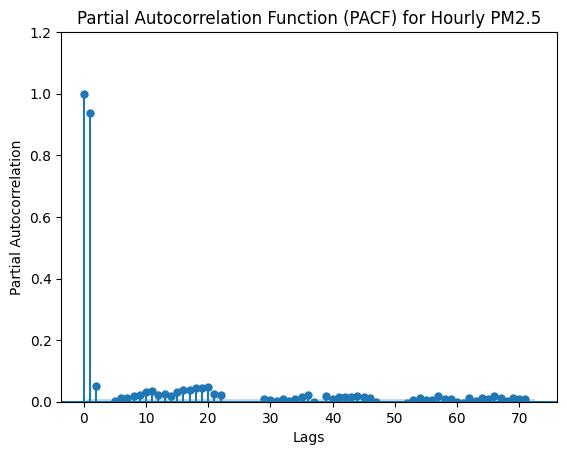

In [ ]:
# Plot Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(df_London_nomissing['pm2.5'], lags=72)
plt.title('Partial Autocorrelation Function (PACF) for Hourly PM2.5')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.ylim(0, 1.2)
plt.show()

# 3. Feature engeering

# Data dimensionality reduction

We use PCA technology to reduce the dimensionality of pollutants except PM2.5.

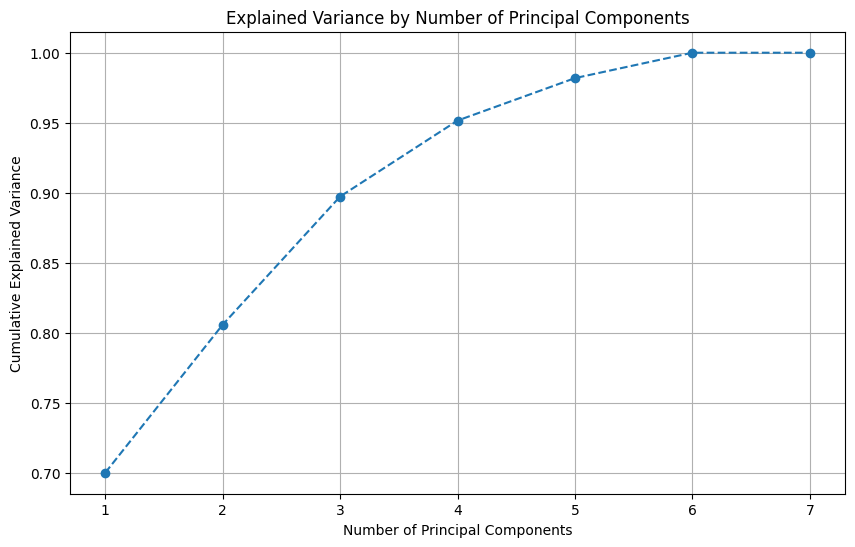

Explained variance ratio for each component: [0.69992948 0.8056812  0.89724997 0.95152269 0.98185995 0.99999984
 1.        ]


In [ ]:
# Extract relevant features
features = ['co', 'nox', 'no2', 'no', 'o3', 'so2', 'pm10']
X = df_London_nomissing[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance ratio to determine the number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

print("Explained variance ratio for each component:", cumulative_variance_ratio)

When the three principal components are retained, the cumulative explained variance reaches 90%.

So we decide to keep the three principal components.


/usr/local/lib/python3.10/dist-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


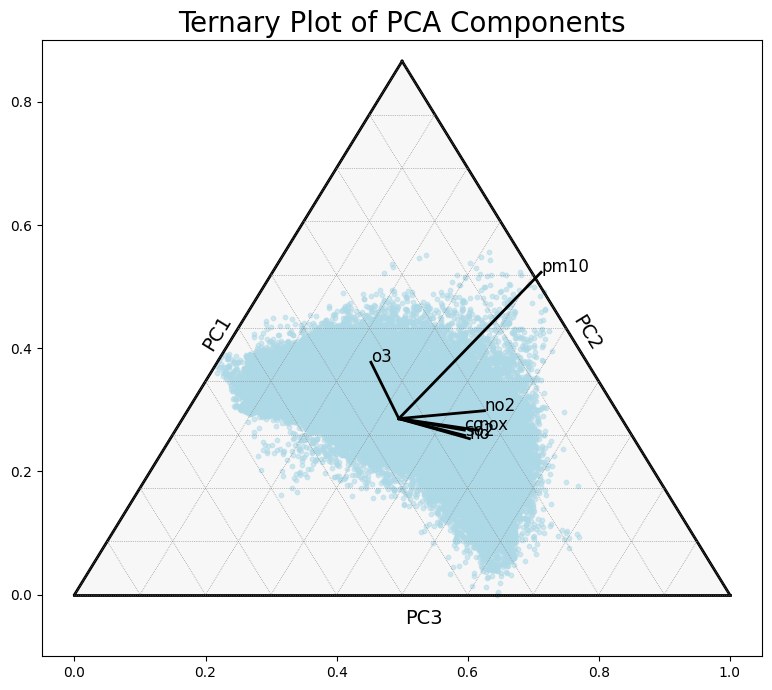

In [ ]:
# Apply PCA and keep 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Normalize PCA components to sum to 1 for ternary plot
X_pca_norm = X_pca - X_pca.min(axis=0)
X_pca_norm /= X_pca_norm.sum(axis=1)[:, None]

# Prepare data for ternary plot
data = [tuple(X_pca_norm[i, :3]) for i in range(X_pca_norm.shape[0])]

# Set ternary plot parameters
scale = 1

# Create ternary plot
fig, tax = ternary.figure(scale=scale)
fig.set_size_inches(9.3, 8)  # Make the triangle larger
tax.boundary(linewidth=2)
tax.gridlines(multiple=0.1, color="grey")

# Set ternary plot labels
fontsize = 14
tax.left_axis_label("PC1", fontsize=fontsize, offset=0.05)
tax.right_axis_label("PC2", fontsize=fontsize, offset=0.05)
tax.bottom_axis_label("PC3", fontsize=fontsize, offset=-0.12)

# Plot data points
tax.scatter(data, marker='o', color='lightblue', alpha=0.5, s=10)

# Plot feature vectors using arrows in matplotlib
feature_vectors = pca.components_.T[:, :3]
origin = [0.33, 0.33, 0.33]

for i, v in enumerate(feature_vectors):
    vector_end = origin + 0.3 * v
    tax.line(origin, vector_end, linewidth=2.0, color='black')
    tax.annotate(text=features[i], position=vector_end, fontsize=12, ha='left', color='black')

# Set ternary plot title
tax.set_title("Ternary Plot of PCA Components", fontsize=20)

# Show ternary plot
plt.show()

PM10 mainly contributes to PC2.

03 contributes to PC1 and PC3.

Other pollutants contribute to PC2 and PC1.

In [ ]:
# Print explained variance ratio
explained_variance_ratio_rounded = [round(ratio, 1) for ratio in pca.explained_variance_ratio_]
print("Explained variance ratio for each component (rounded):", explained_variance_ratio_rounded)

Explained variance ratio for each component (rounded): [0.7, 0.1, 0.1]


In [ ]:
# Convert PCA components to DataFrame
pca_columns = [f'PC{i+1}' for i in range(3)]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)

# Concatenate PCA components with other features from the original dataset
df_final = pd.concat([df_London_nomissing[['code', 'date', 'pm2.5', 'ws', 'wd', 'air_temp']], df_pca], axis=1)
df_final['date'] = pd.to_datetime(df_final['date'])
df_final

,code,date,pm2.5,ws,wd,air_temp,PC1,PC2,PC3
0,KC1,2021-01-01 00:00:00+00:00,30.448,1.5,314.9,-2.1,0.329579,1.493659,0.009872
1,KC1,2021-01-01 01:00:00+00:00,55.802,2.1,318.7,-2.9,1.500821,3.991008,-0.957400
2,KC1,2021-01-01 02:00:00+00:00,28.278,1.9,310.8,-3.6,0.101703,1.333818,0.134547
3,KC1,2021-01-01 03:00:00+00:00,15.613,2.0,309.3,-4.0,-0.489147,0.021434,0.126740
4,KC1,2021-01-01 04:00:00+00:00,19.764,2.0,300.4,-4.5,-0.665272,0.393912,-0.758872
...,...,...,...,...,...,...,...,...,...
52555,MY1,2023-12-31 19:00:00+00:00,8.000,7.9,257.7,7.3,0.184192,-0.372090,-0.146281
52556,MY1,2023-12-31 20:00:00+00:00,12.000,7.8,261.0,7.4,-0.310131,-0.351697,-0.122468
52557,MY1,2023-12-31 21:00:00+00:00,9.000,7.8,260.2,7.4,-0.472206,-0.414343,-0.005787
52558,MY1,2023-12-31 22:00:00+00:00,9.000,7.8,264.8,7.7,-0.454206,-0.235439,-0.071863


# normalisation

## Standardisation & MinMax

In [ ]:
# Features to standardize
features = ['pm2.5', 'ws', 'wd', 'air_temp']

# Standardisation
scaler = StandardScaler()

df_final[features] = scaler.fit_transform(df_final[features])

# Features to minmax scale
features = ['PC1', 'PC2', 'PC3', 'pm2.5', 'ws', 'wd', 'air_temp']

scaler_minmax = MinMaxScaler(feature_range=(0, 1))
df_final[features] = scaler_minmax.fit_transform(df_final[features])

df_final.head()

,code,date,pm2.5,ws,wd,air_temp,PC1,PC2,PC3
0,KC1,2021-01-01 00:00:00+00:00,0.309930,0.109489,0.874722,0.107612,0.127628,0.414973,0.242959
1,KC1,2021-01-01 01:00:00+00:00,0.568858,0.153285,0.885278,0.086614,0.171551,0.632319,0.169436
2,KC1,2021-01-01 02:00:00+00:00,0.287768,0.138686,0.863333,0.068241,0.119082,0.401062,0.252435
3,KC1,2021-01-01 03:00:00+00:00,0.158427,0.145985,0.859167,0.057743,0.096924,0.286844,0.251842
4,KC1,2021-01-01 04:00:00+00:00,0.200819,0.145985,0.834444,0.044619,0.090319,0.319261,0.184526


### conduct Label encoding to the 'code'

In [ ]:
encoder = LabelEncoder()
df_final['code_encoded'] = encoder.fit_transform(df_final['code'])
df_final.head()

,code,date,pm2.5,ws,wd,air_temp,PC1,PC2,PC3,code_encoded
0,KC1,2021-01-01 00:00:00+00:00,0.309930,0.109489,0.874722,0.107612,0.127628,0.414973,0.242959,0
1,KC1,2021-01-01 01:00:00+00:00,0.568858,0.153285,0.885278,0.086614,0.171551,0.632319,0.169436,0
2,KC1,2021-01-01 02:00:00+00:00,0.287768,0.138686,0.863333,0.068241,0.119082,0.401062,0.252435,0
3,KC1,2021-01-01 03:00:00+00:00,0.158427,0.145985,0.859167,0.057743,0.096924,0.286844,0.251842,0
4,KC1,2021-01-01 04:00:00+00:00,0.200819,0.145985,0.834444,0.044619,0.090319,0.319261,0.184526,0


In [ ]:
from google.colab import files

df_final.to_csv('df_final.csv', index=False)

files.download('df_final.csv')

drive.mount('/content/drive')

df_final.to_csv('/content/drive/My Drive/df_final.csv', index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 4. Modelling

## 4.1 Predict the next hour

In [ ]:
from sklearn.model_selection import KFold, RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
df_final = pd.read_csv('/content/drive/My Drive/df_final.csv')

In [ ]:
df_final['date'] = pd.to_datetime(df_final['date'])

In [ ]:
df_final

,code,date,pm2.5,ws,wd,air_temp,PC1,PC2,PC3,code_encoded
0,KC1,2021-01-01 00:00:00+00:00,0.309930,0.109489,0.874722,0.107612,0.127628,0.414973,0.242959,0
1,KC1,2021-01-01 01:00:00+00:00,0.568858,0.153285,0.885278,0.086614,0.171551,0.632319,0.169436,0
2,KC1,2021-01-01 02:00:00+00:00,0.287768,0.138686,0.863333,0.068241,0.119082,0.401062,0.252435,0
3,KC1,2021-01-01 03:00:00+00:00,0.158427,0.145985,0.859167,0.057743,0.096924,0.286844,0.251842,0
4,KC1,2021-01-01 04:00:00+00:00,0.200819,0.145985,0.834444,0.044619,0.090319,0.319261,0.184526,0
...,...,...,...,...,...,...,...,...,...,...
52555,MY1,2023-12-31 19:00:00+00:00,0.080679,0.576642,0.715833,0.354331,0.122175,0.252595,0.231089,1
52556,MY1,2023-12-31 20:00:00+00:00,0.121529,0.569343,0.725000,0.356955,0.103637,0.254370,0.232899,1
52557,MY1,2023-12-31 21:00:00+00:00,0.090891,0.569343,0.722778,0.356955,0.097559,0.248918,0.241768,1
52558,MY1,2023-12-31 22:00:00+00:00,0.090891,0.569343,0.735556,0.364829,0.098234,0.264488,0.236746,1


# Predict the next hour

# Find the best window size (other parameters are fixed)
units = 32
activation = 'tanh'
learning_rate = 0.001
epochs = 20
batch_size = 32

In [ ]:
# Create target variable shifted by 1 hour
df_final['target'] = df_final['pm2.5'].shift(-1)

# Drop the last row with NaN target due to shifting
df_final.dropna(inplace=True)

# Select features
features = ['code_encoded', 'pm2.5', 'ws', 'wd', 'air_temp', 'PC1', 'PC2', 'PC3']

# Function to create sequences for LSTM input
def create_sequences(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:i + window_size][features].values)
        y.append(df.iloc[i + window_size]['target'])
    return np.array(X), np.array(y)

# 2h-->1h

In [ ]:
# Set window size to 2 hours to predict the next 1 hours
window_size = 2
X, y = create_sequences(df_final, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=32, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 1 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 2 hours for predicting next 1 hours
RMSE: 0.03324117344418397
MAE: 0.022407287929510987
MAPE: 32.46072902172192%
R²: 0.8143358025253997


# 6 --> 1h

In [ ]:
# Set window size to 6 hours to predict the next 1 hours
window_size = 6
X, y = create_sequences(df_final, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=32, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 1 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 6 hours for predicting next 1 hours
RMSE: 0.033589903778885134
MAE: 0.022150239274273013
MAPE: 29.09812503706603%
R²: 0.8068305913822613


# 12-->1h

In [ ]:
# Set window size to 12 hours to predict the next 1 hours
window_size = 12
X, y = create_sequences(df_final, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=32, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 1 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 12 hours for predicting next 1 hours
RMSE: 0.03267447440582967
MAE: 0.022080682974298448
MAPE: 31.09124217441369%
R²: 0.8184298842154717


# 24-->1h

In [ ]:
# Set window size to 24 hours to predict the next 1 hours
window_size = 24
X, y = create_sequences(df_final, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=32, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 1 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 24 hours for predicting next 1 hours
RMSE: 0.0318179790819497
MAE: 0.021495573056423703
MAPE: 27.986322386892155%
R²: 0.8296076457368005


## 24 hours

# unites：64

In [ ]:
# Set window size to 24 hours to predict the next 1 hours
window_size = 24
X, y = create_sequences(df_final, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=64, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 1 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 24 hours for predicting next 1 hours
RMSE: 0.03240737889052916
MAE: 0.021677052873373733
MAPE: 29.494858483459502%
R²: 0.8232364427264145


## unites：128

In [ ]:
# Set window size to 24 hours to predict the next 1 hours
window_size = 24
X, y = create_sequences(df_final, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=64, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 1 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 24 hours for predicting next 1 hours
RMSE: 0.03160188892591728
MAE: 0.02170406061598392
MAPE: 32.11425055084705%
R²: 0.8319142082868016


# Predict the next day

In [ ]:
df_nextday = pd.read_csv('/content/drive/My Drive/df_final.csv')

In [ ]:
df_nextday['date'] = pd.to_datetime(df_nextday['date'])

In [ ]:
# Create target variable shifted by 24 hours
df_nextday['target'] = df_nextday['pm2.5'].shift(-24)

# Drop rows with NaN target values due to shifting
df_nextday.dropna(inplace=True)

# Select features
features = ['code_encoded', 'pm2.5', 'ws', 'wd', 'air_temp', 'PC1', 'PC2', 'PC3']

# Function to create sequences for LSTM input
def create_sequences(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size - 24 + 1):
        X.append(df.iloc[i:i + window_size][features].values)
        y.append(df.iloc[i + window_size:i + window_size + 24]['target'].values)
    return np.array(X), np.array(y)

# 24h --> 24h

In [ ]:
# Set window size to 24 hours to predict the next 24 hours
window_size = 24
X, y = create_sequences(df_nextday, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=32, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(24))  # Output layer to predict the next 24 hours
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 24 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 24 hours for predicting next 24 hours
RMSE: 0.054542427936668095
MAE: 0.03937098569754219
MAPE: 66.03229973417639%
R²: 0.5100953615436398


# 36h--> 24h

In [ ]:
# Set window size to 36 hours to predict the next 24 hours
window_size = 36
X, y = create_sequences(df_nextday, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=32, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(24))  # Output layer to predict the next 24 hours
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 24 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 36 hours for predicting next 24 hours
RMSE: 0.05077626460124535
MAE: 0.03648299177482094
MAPE: 58.738842785019806%
R²: 0.5784494625330936


# 48-->24h

In [ ]:
# Set window size to 48 hours to predict the next 24 hours
window_size = 48
X, y = create_sequences(df_nextday, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=32, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(24))  # Output layer to predict the next 24 hours
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)
    # Optional: Evaluate on validation set if needed
    # val_predictions = model.predict(X_val_fold)
    # Compute validation metrics if needed

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 24 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 48 hours for predicting next 24 hours
RMSE: 0.04942980328901332
MAE: 0.035470379924037385
MAPE: 56.806518083178425%
R²: 0.601200456690884


# 48 hours

### 64units

In [ ]:
# Set window size to 48 hours to predict the next 24 hours
window_size = 48
X, y = create_sequences(df_nextday, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=64, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(24))  # Output layer to predict the next 24 hours
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)
    # Optional: Evaluate on validation set if needed
    # val_predictions = model.predict(X_val_fold)
    # Compute validation metrics if needed

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 24 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 48 hours for predicting next 24 hours
RMSE: 0.038412561054436016
MAE: 0.028550865104054593
MAPE: 46.8978214127002%
R²: 0.7591628855651074


###128units

In [ ]:
# Set window size to 48 hours to predict the next 24 hours
window_size = 48
X, y = create_sequences(df_nextday, window_size)

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model function
def build_model(units=128, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(window_size, len(features))))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(24))  # Output layer to predict the next 24 hours
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize Keras Regressor
model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32, verbose=0)

# KFold for cross-validation on the training set
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold)
    # Optional: Evaluate on validation set if needed
    # val_predictions = model.predict(X_val_fold)
    # Compute validation metrics if needed

# Train the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())

# Function to calculate MAPE while ignoring zero actual values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

test_mape = mean_absolute_percentage_error(y_test.flatten(), test_predictions.flatten())

print(f'Window size: {window_size} hours for predicting next 24 hours')
print(f'RMSE: {test_rmse}')
print(f'MAE: {test_mae}')
print(f'MAPE: {test_mape}%')
print(f'R²: {test_r2}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Window size: 48 hours for predicting next 24 hours
RMSE: 0.03297771180288218
MAE: 0.02465398931383012
MAPE: 39.212887641679025%
R²: 0.8224920025044224
